In [4]:
# imports and setup
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display, Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## The following code is used to run the experiment for each model

In [2]:
def run_experiment(model, optimizer, criterion, model_type, steps, num_shuffles=5):
    """
    Run an experiment to train a model on the MNIST dataset for various sizes of training .

    Args:
    - model: The model to be trained.
    - optimizer: The optimizer to use for training.
    - criterion: The loss function criterion.
    - model_type: The type of the model. Can be 'linear_binary', 'linear_multiclass', or 'neural_network'.
    - steps: A list of integers representing the number of training examples to use in each step.
    - num_shuffles: The number of shuffles to perform during the experiment to ensure good results. Default is 5.

    Returns:
    - eval_accuracies: A list of average evaluation accuracies for each number of training examples.
    - train_accuracies: A list of average training accuracies for each number of training examples.
    - gen_gap: A list representing the generalization gap (difference between training and evaluation accuracies).
    - eval_losses: A list of average evaluation losses for each number of training examples.
    - train_losses: A list of average training losses for each number of training examples.
    - loss_gap: A list representing the loss gap (difference between training and evaluation losses).
    - steps: A list of the number 'n' data points selected for top be in the training set.
    """

    print(f"Training with model type: {model_type}")

    model_device = next(model.parameters()).device

    # Model types are 'linear_binary', 'linear_multiclass', and 'neural_network'

    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    if model_type == 'linear_binary':
        mask = (mnist_dataset.targets == 0) | (mnist_dataset.targets == 1)
        X = mnist_dataset.data[mask].view(-1, 28 * 28).float() / 255.0
        y = mnist_dataset.targets[mask]

    else:
      X = mnist_dataset.data.view(-1, 28 * 28).float() / 255.0
      y = mnist_dataset.targets

    # Save 10,000 samples for evaluation
    if model_type == 'linear_binary':
        eval_size = 3000
    else:
        eval_size = 10000

    # Maintaing a list of average eval accuracy for each number of training examples
    eval_accuracies = []
    train_accuracies = []

    train_losses = []
    eval_losses = []

    for k in range(num_shuffles):

        # reset the model parameters so we aren't "using" an unseen data
        model.reset_parameters()
        print(f'Shuffle number: {k}')

        # Generate random indices for shuffling
        random_indices = torch.randperm(len(X))

        # Use the random indices to shuffle the data
        X_shuffled = X[random_indices]
        y_shuffled = y[random_indices]

        # Split into training and evaluation sets
        X_eval, y_eval = X_shuffled[:eval_size].to(model_device), y_shuffled[:eval_size].to(model_device)
        X_train, y_train = X_shuffled[eval_size:].to(model_device), y_shuffled[eval_size:].to(model_device)

        #----------------------------------------------------------------------------------------------------------------------------

        # Only select n examples for training
        # for n in range(1, len(X_train), step_size):
        # steps = [10, 100, 200, 500, 1000, 5000, 10000, 20000, 30000, 40000]
        if k == 0:
          steps.append(len(X_train))
          print(len(X_train))

        for i, n in enumerate(steps):

            print(f'Number of training examples: {n}')

            X_n_train = X_train[:n]
            y_n_train = y_train[:n]

            # Max number of epochs for training
            num_epochs = 100000

            # Training loop
            for epoch in range(num_epochs):
                # Set the model in training mode
                model.train()

                # Forward pass
                outputs = model(X_n_train)

                if model_type == 'linear_binary':
                    # Calculate the loss
                    loss = criterion(outputs, y_n_train.float().view(-1, 1))

                else:
                    loss = criterion(outputs, y_n_train)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Get predictions based on the model type
                if model_type == 'linear_multiclass':
                    predictions = torch.argmax(outputs, dim=1)

                elif model_type == 'linear_binary':
                    predictions = (outputs > 0.5).float()

                elif model_type == 'neural_network':
                    pass

                else:
                    print('Invalid model type')
                    return

                # Calculate training accuracy
                if model_type == 'linear_binary':
                    accuracy  = (predictions == y_n_train.view(-1, 1)).float().mean()
                else:
                    accuracy  = (predictions == y_n_train).float().mean()

                # Print the training loss for each epoch
                if epoch % 1000 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

                # Autostop when the accuracy is close to 100%
                if accuracy.item() >= 0.999:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')
                    break

            # Compute the evaluation accuracy
            model.eval()
            eval_outputs = model(X_eval)

            # Get predictions based on the model type
            if model_type in ['linear_multiclass', 'neural_network']:
                eval_predictions = torch.argmax(eval_outputs, dim=1)

            elif model_type == 'linear_binary':
                eval_predictions = (eval_outputs > 0.5).float()

            else:
                print('Invalid model type')
                return

            if model_type == 'linear_binary':
                eval_loss = criterion(eval_outputs, y_eval.float().view(-1, 1))
                eval_accuracy = (eval_predictions == y_eval.view(-1, 1)).float().mean()
            else:
                eval_accuracy = (eval_predictions == y_eval).float().mean()
                eval_loss = criterion(eval_outputs, y_eval)

            print(f'Evaluation accuracy: {eval_accuracy.item():.4f}')

            if k == 0:
                # Append the evaluation accuracy to the list
                eval_accuracies.append(eval_accuracy.item())
                train_accuracies.append(accuracy.item())

                eval_losses.append(eval_loss.item())
                train_losses.append(loss.item())
            else:
                # Otherwise, add the evaluation accuracy to the existing value
                eval_accuracies[i] += eval_accuracy.item()
                train_accuracies[i] += accuracy.item()

                eval_losses[i] += eval_loss.item()
                train_losses[i] += loss.item()

    # Divide the evaluation accuracies by the number of shuffles to get the average
    eval_accuracies = [x / num_shuffles for x in eval_accuracies]
    train_accuracies = [x / num_shuffles for x in train_accuracies]

    eval_losses = [x / num_shuffles for x in eval_losses]
    train_losses = [x / num_shuffles for x in train_losses]

    # Subtract the eval from train to get the ~generalization gap
    gen_gap = [t - e for t, e in zip(train_accuracies, eval_accuracies)]

    loss_gap = [t - e for t, e in zip(train_losses, eval_losses)]

    return eval_accuracies, train_accuracies, gen_gap, eval_losses, train_losses, loss_gap, steps

## Definition of Single Layer NN

In [ ]:
# Define the neural network model
class SingleLayerNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SingleLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc2(self.ReLU(self.fc1(x)))
        return x

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                print("Reseting Parameters ")
                layer.reset_parameters()

# Hyperparameters
input_size = 28 * 28  # Size of the input image
num_classes = 10  # Number of classes in the dataset
learning_rate = 0.2
batch_size = 32

#----------------------------------------------------------------------------------------------------------------------------

# Number of classes in MNIST
num_classes = 10

# Define the linear model, optimizer, and criterion for multi-class classification
NN_model_multiclass = SingleLayerNN(input_size, num_classes).to(device)
optimizer_multiclass = optim.SGD(NN_model_multiclass.parameters(), lr=learning_rate)
criterion_multiclass = nn.CrossEntropyLoss()

#----------------------------------------------------------------------------------------------------------------------------

eval_accuracies, train_accuracies, gen_gap, eval_losses, train_losses, loss_gap, steps = run_experiment(NN_model_multiclass, optimizer_multiclass, criterion_multiclass, "linear_multiclass", steps=[10, 100, 200, 500, 1000, 5000, 10000, 20000, 30000, 40000])

## Results

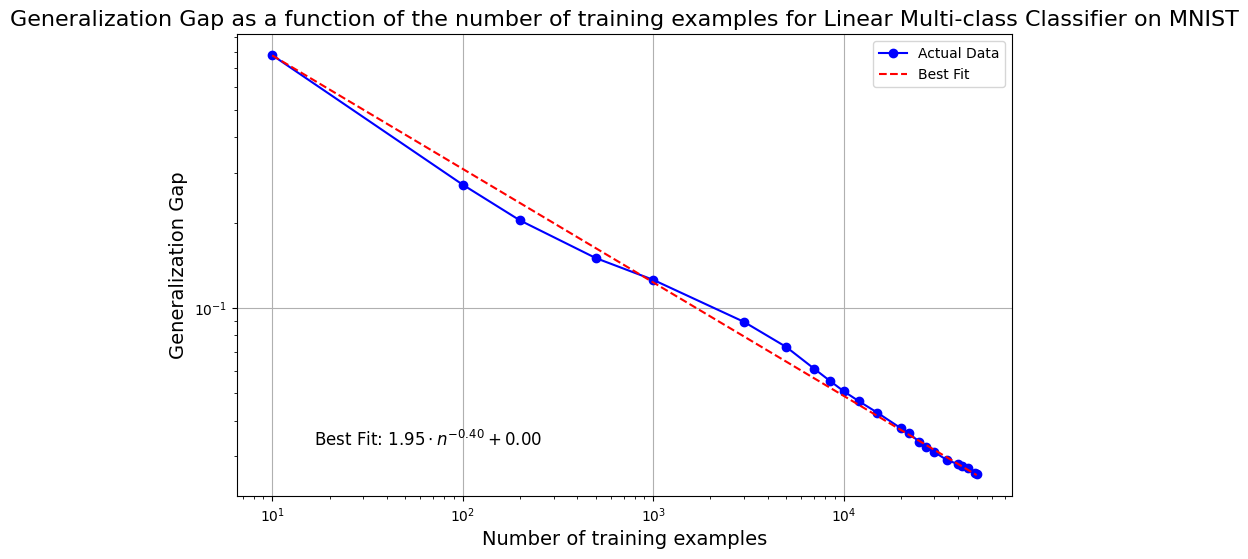

In [12]:
display(Image(filename='SLNN_gen_gap2.png'))

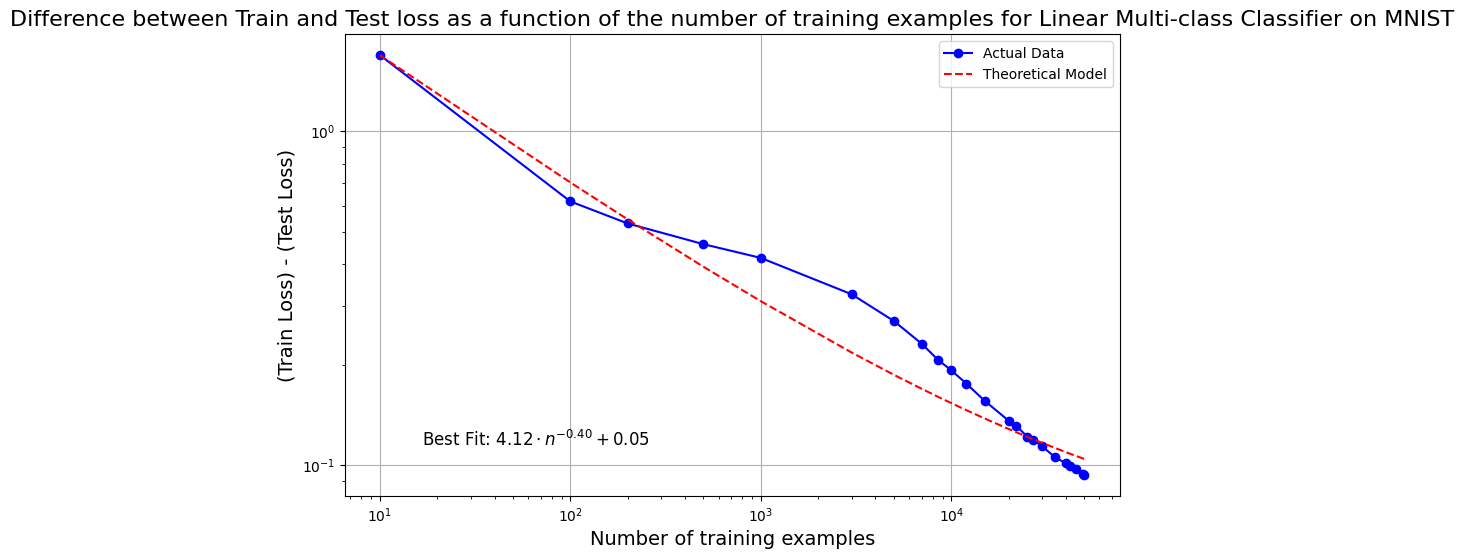

In [13]:
display(Image(filename='SLNN_test_train2.png'))

## Definition of Linear Multi-class Classifier

In [ ]:
# Define the linear model for multi-class classification
class LinearModelMulticlass(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearModelMulticlass, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                print('Resetting parameters')
                layer.reset_parameters()

#----------------------------------------------------------------------------------------------------------------------------

# Number of classes in MNIST
num_classes = 10

# Define the linear model, optimizer, and criterion for multi-class classification
linear_model_multiclass = LinearModelMulticlass(28 * 28, num_classes).to(device)
optimizer_multiclass = optim.SGD(linear_model_multiclass.parameters(), lr=0.2)
criterion_multiclass = nn.CrossEntropyLoss()

#----------------------------------------------------------------------------------------------------------------------------

eval_accuracies, train_accuracies, gen_gap, eval_losses, train_losses, loss_gap, steps = run_experiment(linear_model_multiclass, optimizer_multiclass, criterion_multiclass, "linear_multiclass", steps=[10, 100, 200, 500, 1000, 5000, 10000, 20000, 30000, 40000])

## Results

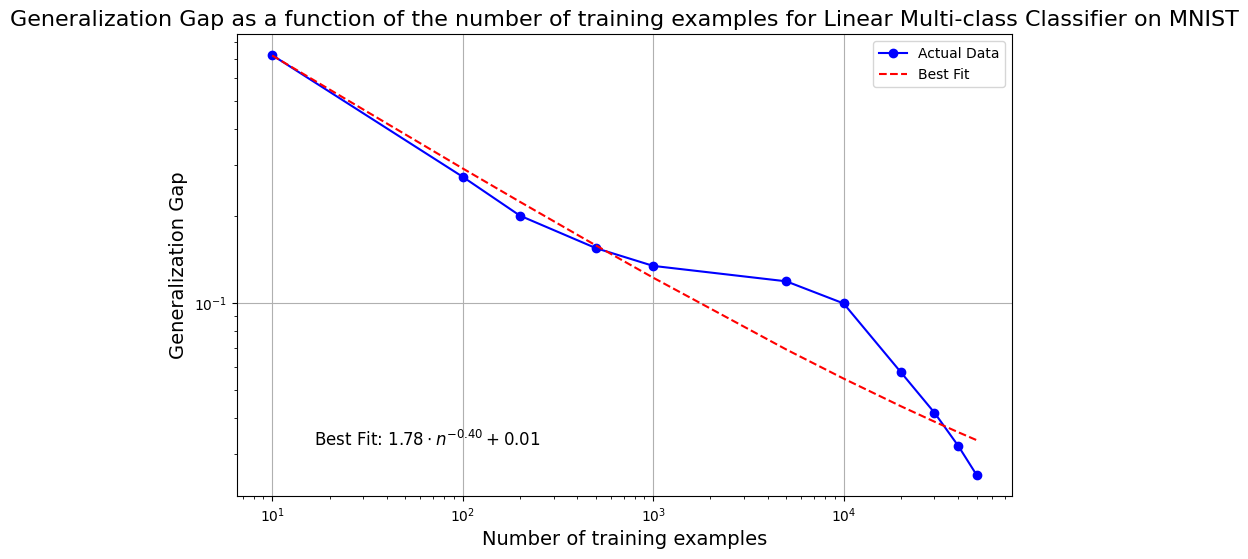

In [9]:
display(Image(filename='gen_gap_multiclass.png'))

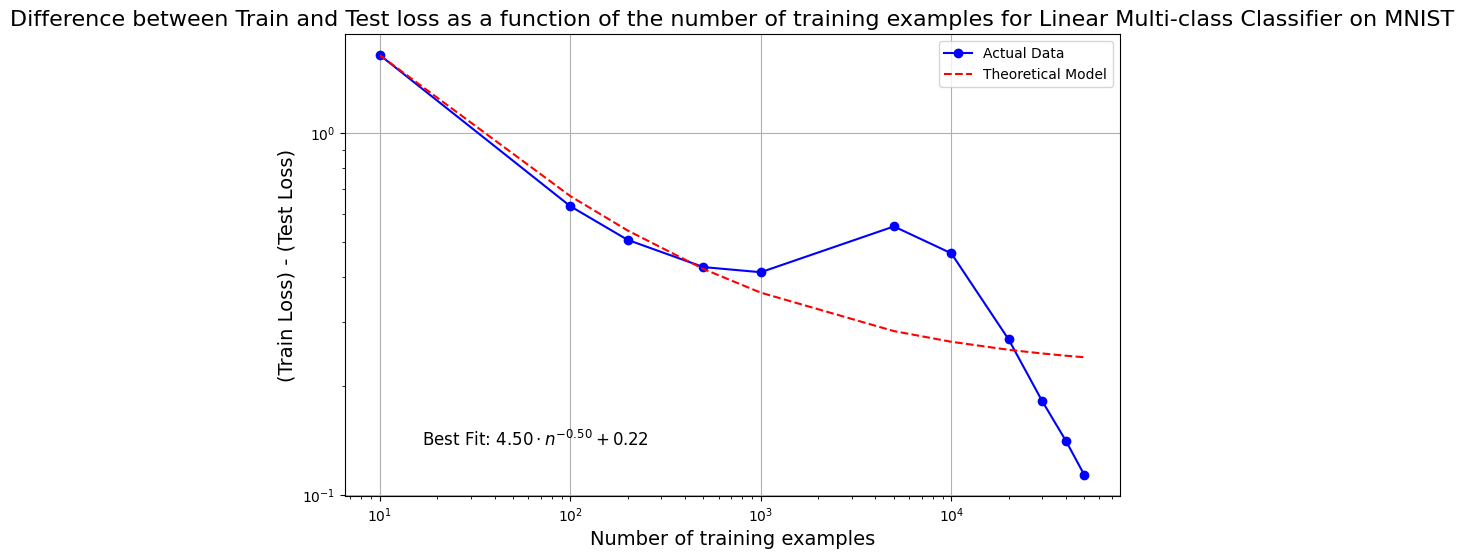

In [8]:
display(Image(filename='train_test_loss_multiclass.png'))

## Definition of Binary Linear Classifier

In [ ]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28 * 28, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                print("Reseting Parameters ")
                layer.reset_parameters()

#----------------------------------------------------------------------------------------------------------------------------

# Create the model
linear_model = LinearClassifier().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)

#----------------------------------------------------------------------------------------------------------------------------

eval_accuracies, train_accuracies, gen_gap, eval_losses, train_losses, loss_gap, steps = run_experiment(linear_model, optimizer, criterion, "linear_binary", steps=list(range(1, 9664)), num_shuffles=2)

## Results

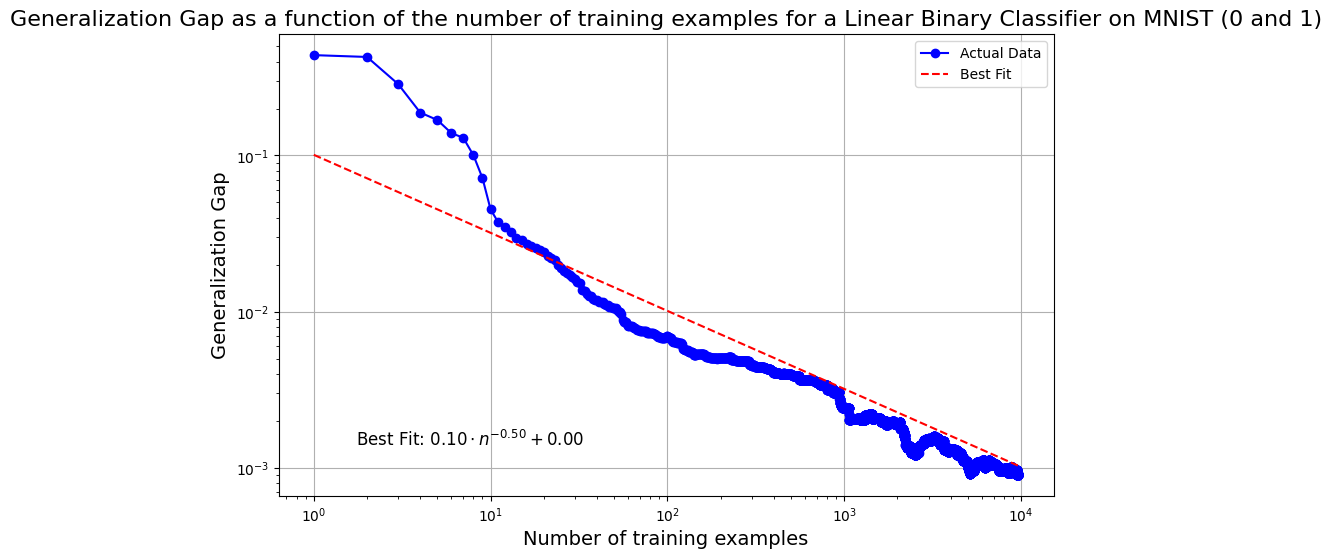

In [14]:
display(Image(filename='gen_gap_binary.png'))

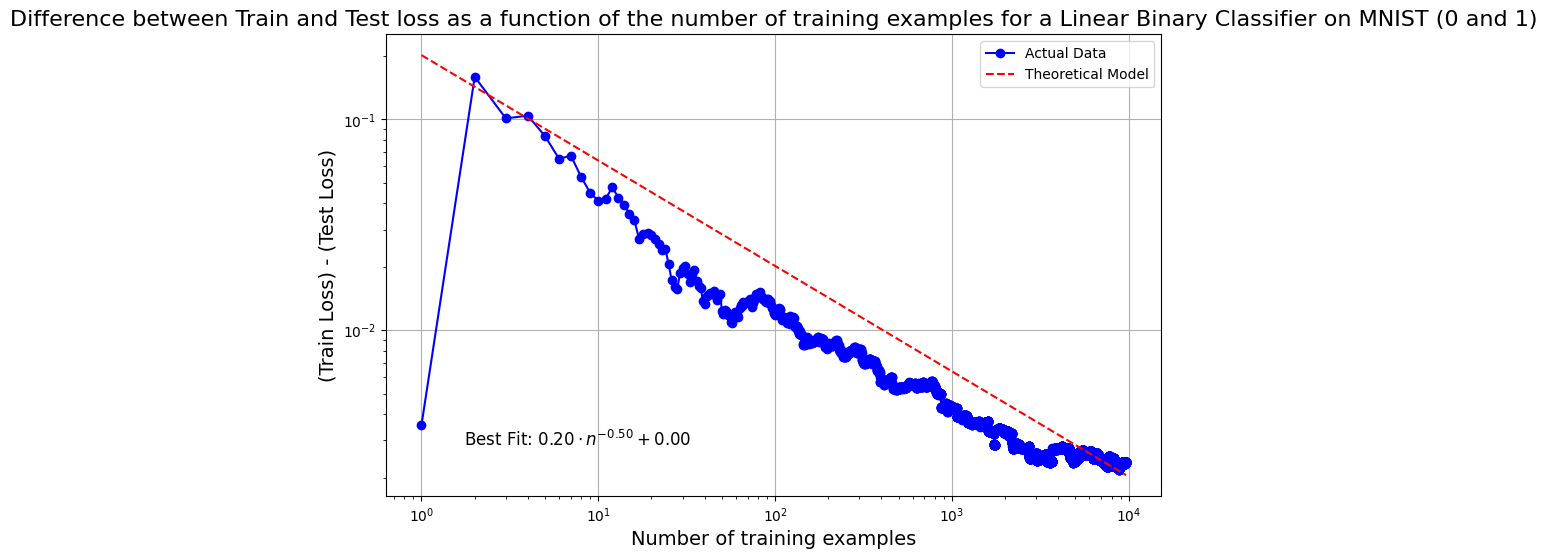

In [15]:
display(Image(filename='train_test_gap_binary.png'))

### Graph the Generalization Gap and find the line of best fit.

The following two cells were used to graph the generalization gap and the difference between the training and test losses. Unfortunately, I didn't spend the time to make them into clean functions. So, the titles of the graphs will have to be modified depending on the model you experimented with.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def theoretical_model(n, a, p, b):
    return a * np.power(n, -p) + b

# Fit the model
best_error = float('inf')
best_params = None

# Range of p values to try
p_values = [0.2, 0.3, 0.4, 0.5]

for p in p_values:
    for a in np.linspace(0, 10, 1000):
        for b in np.linspace(0, 10, 1000):
            predicted = theoretical_model(steps, a, p, b)
            error = np.mean(np.abs(gen_gap - predicted))
            if error < best_error:
                best_error = error
                best_params = (a, p, b)

# Plot the best fit
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')
plt.plot(steps, gen_gap, linestyle='-', marker='o', color='b', label='Actual Data')
plt.plot(steps, theoretical_model(steps, *best_params), linestyle='--', color='r', label='Best Fit')
plt.xlabel('Number of training examples', fontsize=14)
plt.ylabel('Generalization Gap', fontsize=14)
plt.title('Generalization Gap as a function of the number of training examples for Linear Multi-class Classifier on MNIST', fontsize=16)
plt.grid(True)

# Add the equation for the best fit to the graph
eqn_text = f'Best Fit: ${best_params[0]:.2f} \cdot n^{{-{best_params[1]:.2f}}} + {best_params[2]:.2f}$'
plt.text(0.1, 0.1, eqn_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.legend()
plt.show()

print("Best parameters (a, p, b):", best_params)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

negative_loss_gap = [-1 * loss for loss in loss_gap]

# Define the function
def theoretical_model(n, a, p, b):
    return a * np.power(n, -p) + b

# Fit the model
best_error = float('inf')
best_params = None

# Range of p values to try
p_values = [0.2, 0.3, 0.4, 0.5]

for p in p_values:
    for a in np.linspace(0, 10, 1000):
        for b in np.linspace(0, 10, 1000):
            predicted = theoretical_model(steps, a, p, b)
            error = np.mean(np.abs(negative_loss_gap - predicted))
            if error < best_error:
                best_error = error
                best_params = (a, p, b)

# Plot the best fit
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')
plt.plot(steps, negative_loss_gap, linestyle='-', marker='o', color='b', label='Actual Data')
plt.plot(steps, theoretical_model(steps, *best_params), linestyle='--', color='r', label='Theoretical Model')
plt.xlabel('Number of training examples', fontsize=14)
plt.ylabel('(Train Loss) - (Test Loss)', fontsize=14)
plt.title('Difference between Train and Test loss as a function of the number of training examples for Linear Multi-class Classifier on MNIST', fontsize=16)
plt.grid(True)

# Add the equation for the best fit to the graph
eqn_text = f'Best Fit: ${best_params[0]:.2f} \cdot n^{{-{best_params[1]:.2f}}} + {best_params[2]:.2f}$'
plt.text(0.1, 0.1, eqn_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.legend()
plt.show()

print("Best parameters (a, p, b):", best_params)

### A description of what “convergence” rates the simple parameter count bounds imply

We discussed in class that we can bound the generalization gap using Hoffding's inequality.

$$P(\epsilon_{gen}[h] \geq  \epsilon) \leq 2\cdot e^{-2\epsilon^2}$$

Applying the union bound, we can bound any member of our hypothesis class by $\leq |\mathcal{H}| \cdot 2\cdot e^{-2\epsilon^2}$

We then showed that for any element in our hypothesis class $\epsilon_{gen} = O(\sqrt{\frac{d}{n}})$, where d is the parameter count and n is the number of 'training examples'.

From these bounds, given a hypothesis class, we can find the number of training examples that we need for a desired generalization gap!

Surprisingly, we notice from our results that the theory holds reasonably well in practice across a variety of different models. We fit a function of the form $a\cdot n^{-p}+b$ and find that p is either 0.4 or 0.5, which is close to $O(\sqrt{\frac{d}{n}})$, but in the case $p = 0.4$ our bound is worse and will take more training examples than expected. 

However, I don't think there is sufficient evidence to say anything about these bounds with confidence [because this is homework, not a paper :)]. For example, I notice a trend where our results deviate from the best-fit function for both the neural network and multi-class linear classifier. In both of these graphs, between $10^3$ and $10^5$ training examples we see the gap (either between test accuracy and evaluation accuracy or between train loss and evaluation loss) increase away from the trend line and then decrease sharply. I am unsure what is causing this phenomenon, but perhaps we are overfitting or memorizing this data, and once the training data becomes large enough, we no longer can, resulting in a more generalizable model. It’s just conjecture, so perhaps this trend warrants further investigation.